In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint, quad, simps
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Import datasets

In [2]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
fluos.shape, ods.shape

((73, 48), (73, 48))

In [4]:
gates = list(set([i[:-3] for i in fluos.columns.tolist()]))
print(gates)

['e15x32NpuSspS2', 'negative_control', 'e41x32NrdJ1', 'blank', 'e34x30MjaKlbA', 'e32x30SspGyrB', 'e38x32gp418', 'e42x32STIMPDH1', 'e16x33NrdA2', 'e20x32gp411', 'positive_control', 'e11x32STPhoRadA']


#### ODE Models

In [5]:
#static model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

#growth curve
def od_wrapper(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(t, OD[0], r, c) * OD[0]
        return dOD
    
    od_sol = odeint(od_model, c0, t, (r, c))
    return np.array(od_sol[:,0])

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model without auto-fluorescence term
def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#### Fitting a Single Gate (No Auto-fluorescence)

In [6]:
sel = 9
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

9 e20x32gp411


Sampling initial guesses.

In [6]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [7]:
par = {
    'bn': [1e-1, 0, 1e1],
    'bc': [1e-1, 0, 1e1],
    'bg': [1e-2, 0, 1e1],
    'syn_ECFn': [4e0, 0, 1e2],
    'syn_ECFc': [4e0, 0, 1e2],
    'syn_ECF': [50e-10, 0, 1e-4],
    'deg': [7e-3, 0, 1e-1],
    'syn_GFP': [1e4, 0, 1e5],
    'deg_GFP': [1e-2, 0, 1e0],
    # 'a': [1e-2, 0, 1e1],
    'K': [1e-1, 0, 1e2],
    'n': [2e0, 0, 4],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def fit_single_state(gate, fluo, od, ind1, ind2, sampled=None):
    
    num_od_params = 3
    num_vars = 4
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, (o_params[0], o_params[1]), pd.Series(np.append(np.zeros(num_vars), o_params[2])))
        return pd.Series(fit[3])
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    o_params, o_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
    
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    
    if sampled is None:
        f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    else:
        f_p0 = randomSearch(10, len(f_bounds[0]), fluo.index, fluo, f_bounds, o_params, ind1, ind2)
    
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys()), 'value': np.append(f_params, o_params),
                         'error': np.append(np.sqrt(np.diag(f_cov)), np.sqrt(np.diag(o_cov)))})
    f_df.insert(loc=0, column='gate', value=gate)
    
    return f_df, f_sim, fluo.index, fluo

In [10]:
n = 3 #induction state in decimal
f_df, f_sim, f_t, f_data = fit_single_state(gate, fluo_sel.iloc[:,n], od_sel.iloc[:,n], int(n/2), n%2, True)

100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


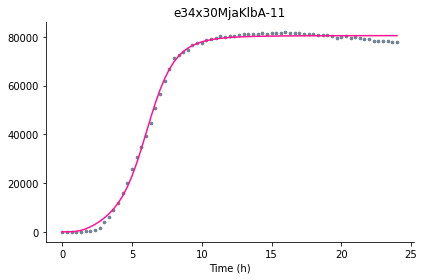

In [11]:
plt.scatter(f_t/60, f_data, c='slategrey', s=7)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(gate + '-' + format(3, '02b'))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Fitting All Gates

In [ ]:
#objective function
def computeSSE_global(f_p0, f_t, f_data, f_bounds, o_params_all):
    
    num_states = 9
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, c, i, a0, a1, a2, a3, a4, a5, a6, a7, a8, b0, b1, b2, b3, b4, b5, b6, b7, b8, d0, d1, d2, d3, d4, d5, d6, d7, d8,
                 e0, e1, e2, e3, e4, e5, e6, e7, e8, f0, f1, f2, f3, f4, f5, f6, f7, f8, g0, g1, g2, g3, g4, g5, g6, g7, g8,
                 h0, h1, h2, h3, h4, h5, h6, h7, h8, j0, j1, j2, j3, j4, j5, j6, j7, j8, k0, k1, k2, k3, k4, k5, k6, k7, k8):
        aa = [a0, a1, a2, a3, a4, a5, a6, a7, a8]
        bb = [b0, b1, b2, b3, b4, b5, b6, b7, b8]
        dd = [d0, d1, d2, d3, d4, d5, d6, d7, d8]
        ee = [e0, e1, e2, e3, e4, e5, e6, e7, e8]
        ff = [f0, f1, f2, f3, f4, f5, f6, f7, f8]
        gg = [g0, g1, g2, g3, g4, g5, g6, g7, g8]
        hh = [h0, h1, h2, h3, h4, h5, h6, h7, h8]
        jj = [j0, j1, j2, j3, j4, j5, j6, j7, j8]
        kk = [k0, k1, k2, k3, k4, k5, k6, k7, k8]
        result = [model_fit_inner(f_t[:int(len(f_t)/num_states)], aa[n], bb[n], c, dd[n], ee[n], ff[n], gg[n], hh[n], i, jj[n], kk[n], 1, 1, \
                                   (o_params_all[n][0], o_params_all[n][1]), [0, 0, 0, 0, o_params_all[n][2]]) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    
    error = [(val-sal)**2 for val, sal in zip(f_sim, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params_all):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params_all)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
par = {
    'bn0': [1e-1, 0, 1e1], #a
    'bn1': [1e-1, 0, 1e1], #a
    'bn2': [1e-1, 0, 1e1], #a
    'bn3': [1e-1, 0, 1e1], #a
    'bn4': [1e-1, 0, 1e1], #a
    'bn5': [1e-1, 0, 1e1], #a
    'bn6': [1e-1, 0, 1e1], #a
    'bn7': [1e-1, 0, 1e1], #a
    'bn8': [1e-1, 0, 1e1], #a
    'bc0': [1e-1, 0, 1e1], #b
    'bc1': [1e-1, 0, 1e1], #b
    'bc2': [1e-1, 0, 1e1], #b
    'bc3': [1e-1, 0, 1e1], #b
    'bc4': [1e-1, 0, 1e1], #b
    'bc5': [1e-1, 0, 1e1], #b
    'bc6': [1e-1, 0, 1e1], #b
    'bc7': [1e-1, 0, 1e1], #b
    'bc8': [1e-1, 0, 1e1], #b
    'bg': [1e-2, 0, 1e1], #c - shared
    'syn_ECFn0': [4e0, 0, 1e2], #d
    'syn_ECFn1': [4e0, 0, 1e2], #d
    'syn_ECFn2': [4e0, 0, 1e2], #d
    'syn_ECFn3': [4e0, 0, 1e2], #d
    'syn_ECFn4': [4e0, 0, 1e2], #d
    'syn_ECFn5': [4e0, 0, 1e2], #d
    'syn_ECFn6': [4e0, 0, 1e2], #d
    'syn_ECFn7': [4e0, 0, 1e2], #d
    'syn_ECFn8': [4e0, 0, 1e2], #d
    'syn_ECFc0': [4e0, 0, 1e2], #e
    'syn_ECFc1': [4e0, 0, 1e2], #e
    'syn_ECFc2': [4e0, 0, 1e2], #e
    'syn_ECFc3': [4e0, 0, 1e2], #e
    'syn_ECFc4': [4e0, 0, 1e2], #e
    'syn_ECFc5': [4e0, 0, 1e2], #e
    'syn_ECFc6': [4e0, 0, 1e2], #e
    'syn_ECFc7': [4e0, 0, 1e2], #e
    'syn_ECFc8': [4e0, 0, 1e2], #e
    'syn_ECF0': [50e-10, 0, 1e-4], #f
    'syn_ECF1': [50e-10, 0, 1e-4], #f
    'syn_ECF2': [50e-10, 0, 1e-4], #f
    'syn_ECF3': [50e-10, 0, 1e-4], #f
    'syn_ECF4': [50e-10, 0, 1e-4], #f
    'syn_ECF5': [50e-10, 0, 1e-4], #f
    'syn_ECF6': [50e-10, 0, 1e-4], #f
    'syn_ECF7': [50e-10, 0, 1e-4], #f
    'syn_ECF8': [50e-10, 0, 1e-4], #f
    'deg0': [7e-3, 0, 1e-1], #g
    'deg1': [7e-3, 0, 1e-1], #g
    'deg2': [7e-3, 0, 1e-1], #g
    'deg3': [7e-3, 0, 1e-1], #g
    'deg4': [7e-3, 0, 1e-1], #g
    'deg5': [7e-3, 0, 1e-1], #g
    'deg6': [7e-3, 0, 1e-1], #g
    'deg7': [7e-3, 0, 1e-1], #g
    'deg8': [7e-3, 0, 1e-1], #g
    'syn_GFP0': [1e4, 0, 1e5], #h
    'syn_GFP1': [1e4, 0, 1e5], #h
    'syn_GFP2': [1e4, 0, 1e5], #h
    'syn_GFP3': [1e4, 0, 1e5], #h
    'syn_GFP4': [1e4, 0, 1e5], #h
    'syn_GFP5': [1e4, 0, 1e5], #h
    'syn_GFP6': [1e4, 0, 1e5], #h
    'syn_GFP7': [1e4, 0, 1e5], #h
    'syn_GFP8': [1e4, 0, 1e5], #h
    'deg_GFP': [1e-2, 0, 1e0], #i - shared
    # 'a': [1e-2, 0, 1e1],
    'K0': [1e-1, 0, 1e2], #j
    'K1': [1e-1, 0, 1e2], #j
    'K2': [1e-1, 0, 1e2], #j
    'K3': [1e-1, 0, 1e2], #j
    'K4': [1e-1, 0, 1e2], #j
    'K5': [1e-1, 0, 1e2], #j
    'K6': [1e-1, 0, 1e2], #j
    'K7': [1e-1, 0, 1e2], #j
    'K8': [1e-1, 0, 1e2], #j
    'n0': [2e0, 0, 4], #k
    'n1': [2e0, 0, 4], #k
    'n2': [2e0, 0, 4], #k
    'n3': [2e0, 0, 4], #k
    'n4': [2e0, 0, 4], #k
    'n5': [2e0, 0, 4], #k
    'n6': [2e0, 0, 4], #k
    'n7': [2e0, 0, 4], #k
    'n8': [2e0, 0, 4], #k
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def fit_all_states(fluo, od):
    
    num_states = 9
    num_od_params = 3
    
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    
    o_params_all = []
    o_df = pd.DataFrame()
    for i in range(od.shape[1]):
        o_params, o_cov = curve_fit(od_wrapper, od.index, od.iloc[:,i], bounds=o_bounds)
        #o_df = o_df.append(pd.DataFrame({'value': o_params, 'error': np.sqrt(np.diag(o_cov))}))
        o_df = o_df.append(pd.DataFrame({'parameter': [j + '_' + str(i) for j in list(par.keys())[-num_od_params:]],
                                         'value': o_params, 'error': np.sqrt(np.diag(o_cov))}))
        o_params_all.append(o_params)
    
    #f_p0 = [i[0] for i in list(par.values())][:-num_od_params]
    f_bounds = [[i[1] for i in list(par.values())][:-num_od_params], [i[2] for i in list(par.values())][:-num_od_params]]
    f_p0 = randomSearch(15, len(f_bounds[0]), f_t, f_data, f_bounds, o_params_all)
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, c, i, a0, a1, a2, a3, a4, a5, a6, a7, a8, b0, b1, b2, b3, b4, b5, b6, b7, b8, d0, d1, d2, d3, d4, d5, d6, d7, d8,
                 e0, e1, e2, e3, e4, e5, e6, e7, e8, f0, f1, f2, f3, f4, f5, f6, f7, f8, g0, g1, g2, g3, g4, g5, g6, g7, g8,
                 h0, h1, h2, h3, h4, h5, h6, h7, h8, j0, j1, j2, j3, j4, j5, j6, j7, j8, k0, k1, k2, k3, k4, k5, k6, k7, k8):
        aa = [a0, a1, a2, a3, a4, a5, a6, a7, a8]
        bb = [b0, b1, b2, b3, b4, b5, b6, b7, b8]
        dd = [d0, d1, d2, d3, d4, d5, d6, d7, d8]
        ee = [e0, e1, e2, e3, e4, e5, e6, e7, e8]
        ff = [f0, f1, f2, f3, f4, f5, f6, f7, f8]
        gg = [g0, g1, g2, g3, g4, g5, g6, g7, g8]
        hh = [h0, h1, h2, h3, h4, h5, h6, h7, h8]
        jj = [j0, j1, j2, j3, j4, j5, j6, j7, j8]
        kk = [k0, k1, k2, k3, k4, k5, k6, k7, k8]
        result = [model_fit_inner(fluo.index, aa[n], bb[n], c, dd[n], ee[n], ff[n], gg[n], hh[n], i, jj[n], kk[n], 1, 1, \
                                   (o_params_all[n][0], o_params_all[n][1]), [0, 0, 0, 0, o_params_all[n][2]]) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys())[:-num_od_params], 'value': f_params, 'error': np.sqrt(np.diag(f_cov))})
    #f_df = pd.DataFrame({'value': f_params, 'error': np.sqrt(np.diag(f_cov))})
    
    f_df = f_df.append(o_df)
    #f_df.insert(loc=0, column='gate', value=gate)
    
    return f_t, f_df.reset_index(drop=True), f_sim, f_data

In [ ]:
f_t_all, f_df_all, f_sim_all, f_data_all = fit_all_states(fluo_sels, od_sels)

In [ ]:
f, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 5))
axr = axs.ravel()
cols = fluo_sels.columns.tolist()
idx = len(fluo_sels)
for i, ax in enumerate(axr):
    ax.scatter(f_t_all[idx*i:idx*(i+1)]/60, f_data_all[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_all[idx*i:idx*(i+1)]/60, f_sim_all[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(cols[i])
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 5))
axr = axs.ravel()
cols = fluo_sels.columns.tolist()
idx = len(fluo_sels)
for i, ax in enumerate(axr):
    ax.scatter(f_t_all[idx*i:idx*(i+1)]/60, f_data_all[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_all[idx*i:idx*(i+1)]/60, f_sim_all[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(cols[i])
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Simulating Fixed Parameters

In [7]:
par = {
    'bn': [1e-1, 0, 1e1],
    'bc': [1e-1, 0, 1e1],
    'bg': [1e-2, 0, 1e1],
    'syn_ECFn': [4e0, 0, 1e2],
    'syn_ECFc': [4e0, 0, 1e2],
    'syn_ECF': [50e-10, 0, 1e-4],
    'deg': [7e-3, 0, 1e-1],
    'syn_GFP': [2e3, 0, 1e5],
    'deg_GFP': [1e-2, 0, 1e0],
    # 'a': [1e-2, 0, 1e1],
    'K': [1e-1, 0, 1e2],
    'n': [2e0, 0, 4],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}

def simulate_single_state(gate, fluo, od, ind1, ind2, f_params=None):
    
    num_od_params = 3
    num_vars = 4
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, (o_params[0], o_params[1]), pd.Series(np.append(np.zeros(num_vars), o_params[2])))
        return pd.Series(fit[3])
    
    o_p0 = [i[0] for i in list(par.values())][-num_od_params:]
    o_bounds = [[i[1] for i in list(par.values())][-num_od_params:], [i[2] for i in list(par.values())][-num_od_params:]]
    o_params, o_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
    
    if f_params==None:
        f_params = [i[0] for i in list(par.values())][:-num_od_params]
    f_sim = model_fit(fluo.index, *f_params)
    
    return f_sim

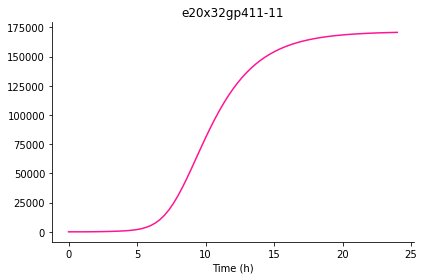

In [9]:
n = 3 #induction state in decimal
f_t = fluo_sel.iloc[:,n].index
f_sim = simulate_single_state(gate, fluo_sel.iloc[:,n], od_sel.iloc[:,n], int(n/2), n%2)
plt.plot(f_t/60, f_sim, c='deeppink')
plt.title(gate + '-' + format(3, '02b'))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Sensitivity Analysis

In [96]:
sel = 0
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

0 e15x32NpuSspS2


In [133]:
par_list = list(par.keys())[:-3]
num_samples = 100

datas = []
y_aucs = []
y_alls = []

for selected in tqdm(par_list):
    
    par_feats = []
    for p in par_list:
        if p==selected:
            par_feats.append(np.random.uniform(par[p][1], par[p][2], num_samples))
        else:
            #val = par[p][0]
            val = np.random.uniform(par[p][1], par[p][2])
            par_feats.append([val for i in range(num_samples)])
    par_feats = np.array(par_feats)

    data = pd.DataFrame(par_feats).T
    data.columns = par_list
    data = data.sort_values(selected)

    y_auc = []
    y_all = []
    for i, row in data.iterrows(): 
        f_sim = simulate_single_state(gate, fluo_sel.iloc[:,n], od_sel.iloc[:,n], int(n/2), n%2, row.tolist())
        y_auc.append(simps(f_sim))
        y_all.append(f_sim)
        
    datas.append(data)
    y_aucs.append(y_auc)
    y_alls.append(y_all)

100%|██████████| 11/11 [02:17<00:00, 12.51s/it]


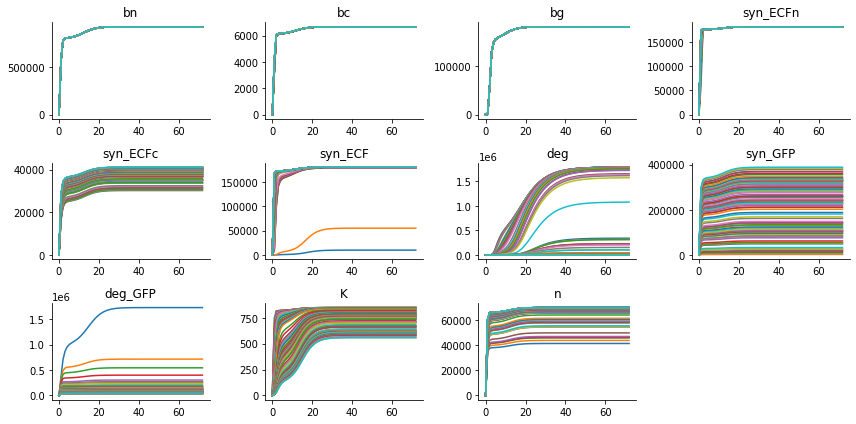

In [134]:
#all fixed values are sampled
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
ax = axs.ravel()
for j in range(len(datas)):
    data = datas[j]
    y_all = y_alls[j]
    for i in range(len(data)):
        ax[j].plot(np.arange(len(y_all[i])), y_all[i])
    ax[j].set_title(par_list[j])
for j in range(len(datas), 12):
    ax[j].set_visible(False)
plt.tight_layout()
sns.despine()

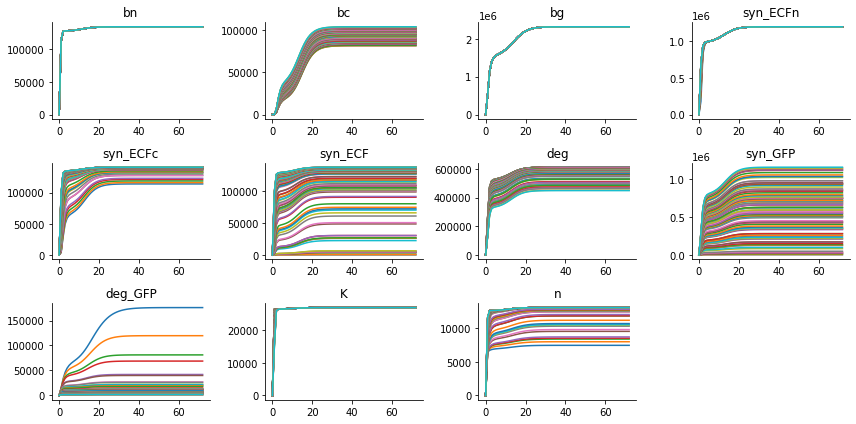

In [131]:
#all fixed values are sampled
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
ax = axs.ravel()
for j in range(len(datas)):
    data = datas[j]
    y_all = y_alls[j]
    for i in range(len(data)):
        ax[j].plot(np.arange(len(y_all[i])), y_all[i])
    ax[j].set_title(par_list[j])
for j in range(len(datas), 12):
    ax[j].set_visible(False)
plt.tight_layout()
sns.despine()

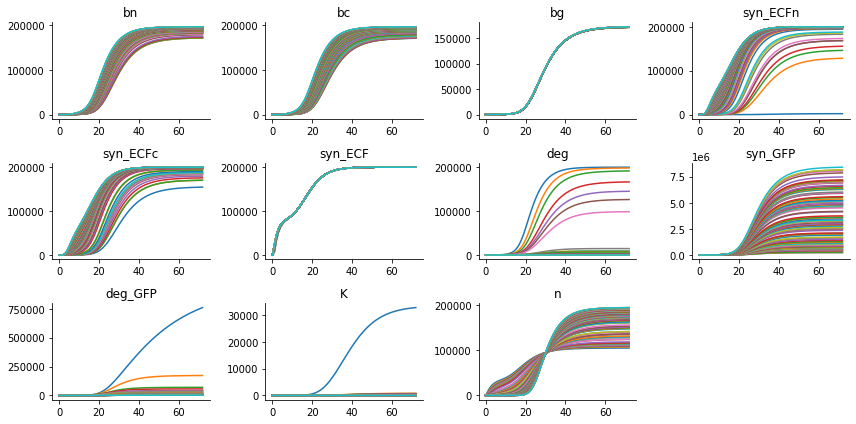

In [127]:
#all fixed values are from init_guesses
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
ax = axs.ravel()
for j in range(len(datas)):
    data = datas[j]
    y_all = y_alls[j]
    for i in range(len(data)):
        ax[j].plot(np.arange(len(y_all[i])), y_all[i])
    ax[j].set_title(par_list[j])
for j in range(len(datas), 12):
    ax[j].set_visible(False)
plt.tight_layout()
sns.despine()

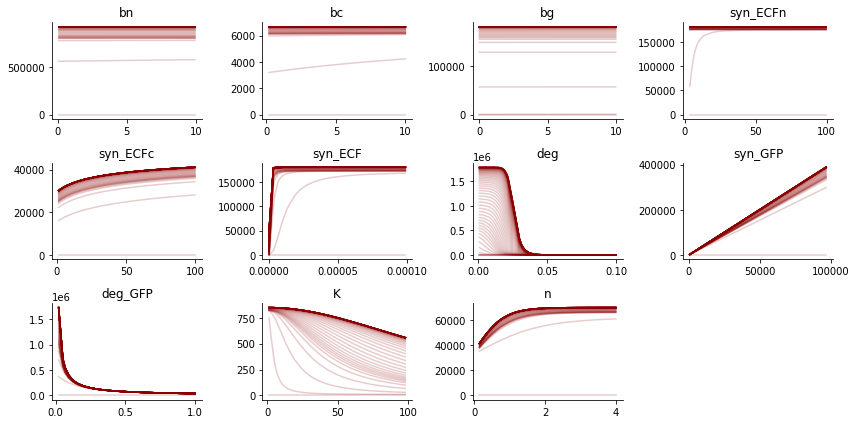

In [135]:
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
ax = axs.ravel()
for j in range(len(datas)):
    data = datas[j]
    y_all = y_alls[j]
    for i in range(len(y_all[0])):
        ax[j].plot(data[par_list[j]], [y[i] for y in y_all], color='darkred', alpha=0.2)
    ax[j].set_title(par_list[j])
for j in range(len(datas), 12):
    ax[j].set_visible(False)
plt.tight_layout()
sns.despine()

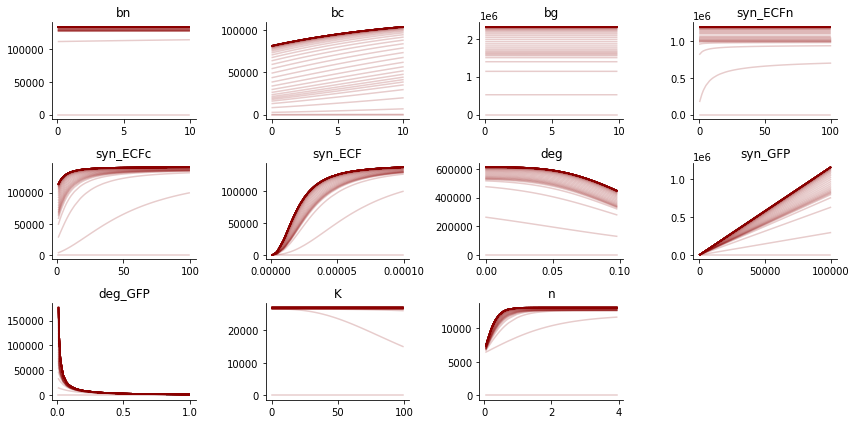

In [132]:
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
ax = axs.ravel()
for j in range(len(datas)):
    data = datas[j]
    y_all = y_alls[j]
    for i in range(len(y_all[0])):
        ax[j].plot(data[par_list[j]], [y[i] for y in y_all], color='darkred', alpha=0.2)
    ax[j].set_title(par_list[j])
for j in range(len(datas), 12):
    ax[j].set_visible(False)
plt.tight_layout()
sns.despine()

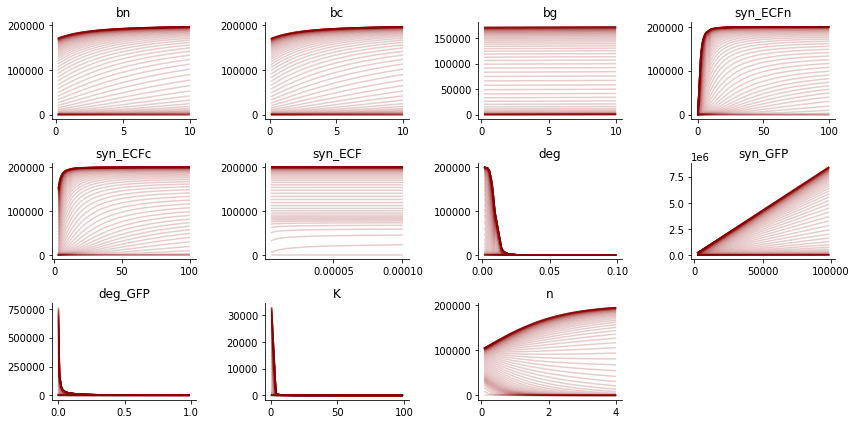

In [129]:
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
ax = axs.ravel()
for j in range(len(datas)):
    data = datas[j]
    y_all = y_alls[j]
    for i in range(len(y_all[0])):
        ax[j].plot(data[par_list[j]], [y[i] for y in y_all], color='darkred', alpha=0.2)
    ax[j].set_title(par_list[j])
for j in range(len(datas), 12):
    ax[j].set_visible(False)
plt.tight_layout()
sns.despine()

#### Sensitivity Analysis (Too Complex)

In [12]:
sel = 10
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

10 positive_control


In [13]:
par_list = list(par.keys())[:-3]
par_feats = []
for p in par_list:
    par_feats.append(np.random.uniform(par[p][1], par[p][2], 10000))
par_feats = np.array(par_feats)
    
data = pd.DataFrame(par_feats).T
data.columns = par_list

In [29]:
X = data.copy()

In [157]:
sel = 10
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

10 e38x32gp418


In [158]:
y_16 = []
y_24 = []
y_auc = []
y_all = []
for i, row in tqdm(data.iterrows()): 
    f_sim = simulate_single_state(gate, fluo_sel.iloc[:,n], od_sel.iloc[:,n], int(n/2), n%2, row.tolist())
    y_16.append(f_sim.iloc[16*3])
    y_24.append(f_sim.iloc[24*3])
    y_auc.append(simps(f_sim))
    y_all.append(f_sim)

10000it [12:02, 13.84it/s]


In [89]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import plot_partial_dependence, partial_dependence

from sklearn.metrics import r2_score

In [159]:
cvs = cross_val_score(GradientBoostingRegressor(), X, y_16, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())
cvs = cross_val_score(RandomForestRegressor(), X, y_16, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())

0.7925024464911414 0.1277829705763227
0.8055080078359358 0.10073775617577328


In [95]:
#first
cvs = cross_val_score(GradientBoostingRegressor(), X, y_24, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())
cvs = cross_val_score(RandomForestRegressor(), X, y_24, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())

0.7723350629623967 0.1402139017002823
0.7894773213683693 0.09041608413923927


In [160]:
#second
cvs = cross_val_score(GradientBoostingRegressor(), X, y_24, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())
cvs = cross_val_score(RandomForestRegressor(), X, y_24, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())

0.7730433089676175 0.15086513258742934
0.7691275954992213 0.11086838846625134


In [96]:
#first
cvs = cross_val_score(GradientBoostingRegressor(), X, y_auc, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())
cvs = cross_val_score(RandomForestRegressor(), X, y_auc, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())

0.8308081766350099 0.09726562012525673
0.8240210158175678 0.07163381460989107


In [161]:
#second
cvs = cross_val_score(GradientBoostingRegressor(), X, y_auc, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())
cvs = cross_val_score(RandomForestRegressor(), X, y_auc, cv=5, scoring='r2')
print(cvs.mean(), cvs.std())

0.8420298897502487 0.084300510725403
0.8230391014226208 0.07622547664840333


0.9119889094802875
0.8582015581874229
0.8805360856391978
0.8065263883955796
0.9038423284934078
0.8495123959900394


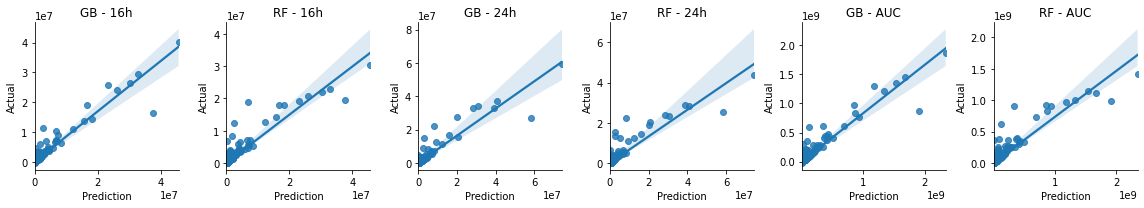

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y_16, random_state=0)

fig, ax = plt.subplots(1, 6, figsize=(16, 3))
gb1 = GradientBoostingRegressor(random_state=0)
gb1.fit(X_train, y_train)
y_pred = gb1.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[0])
ax[0].set_title('GB - 16h')
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Actual')

rf1 = RandomForestRegressor(random_state=0)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[1])
ax[1].set_title('RF - 16h')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Actual')

X_train, X_test, y_train, y_test = train_test_split(X, y_24, random_state=0)

gb2 = GradientBoostingRegressor(random_state=0)
gb2.fit(X_train, y_train)
y_pred = gb2.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[2])
ax[2].set_title('GB - 24h')
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Actual')

rf2 = RandomForestRegressor(random_state=0)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[3])
ax[3].set_title('RF - 24h')
ax[3].set_xlabel('Prediction')
ax[3].set_ylabel('Actual')

X_train, X_test, y_train, y_test = train_test_split(X, y_auc, random_state=0)

gb3 = GradientBoostingRegressor(random_state=0)
gb3.fit(X_train, y_train)
y_pred = gb3.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[4])
ax[4].set_title('GB - AUC')
ax[4].set_xlabel('Prediction')
ax[4].set_ylabel('Actual')

rf3 = RandomForestRegressor(random_state=0)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[5])
ax[5].set_title('RF - AUC')
ax[5].set_xlabel('Prediction')
ax[5].set_ylabel('Actual')

sns.despine()
plt.tight_layout()
plt.show()

0.8828073180985037
0.8459459878996228
0.8795177816236288
0.8087545469243596
0.9134255863958309
0.8722581573537307


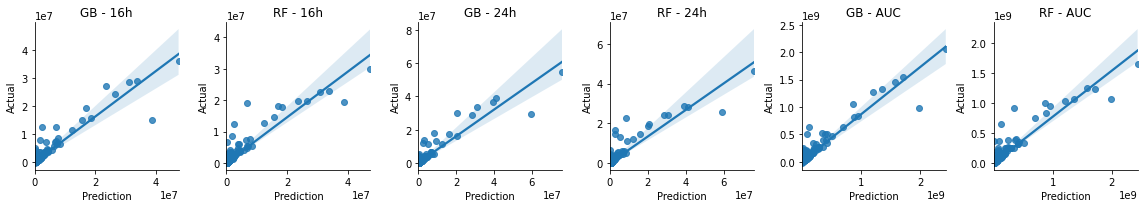

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y_16, random_state=0)

fig, ax = plt.subplots(1, 6, figsize=(16, 3))
gb1 = GradientBoostingRegressor(random_state=0)
gb1.fit(X_train, y_train)
y_pred = gb1.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[0])
ax[0].set_title('GB - 16h')
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Actual')

rf1 = RandomForestRegressor(random_state=0)
rf1.fit(X_train, y_train)
y_pred = rf1.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[1])
ax[1].set_title('RF - 16h')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Actual')

X_train, X_test, y_train, y_test = train_test_split(X, y_24, random_state=0)

gb2 = GradientBoostingRegressor(random_state=0)
gb2.fit(X_train, y_train)
y_pred = gb2.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[2])
ax[2].set_title('GB - 24h')
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Actual')

rf2 = RandomForestRegressor(random_state=0)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[3])
ax[3].set_title('RF - 24h')
ax[3].set_xlabel('Prediction')
ax[3].set_ylabel('Actual')

X_train, X_test, y_train, y_test = train_test_split(X, y_auc, random_state=0)

gb3 = GradientBoostingRegressor(random_state=0)
gb3.fit(X_train, y_train)
y_pred = gb3.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[4])
ax[4].set_title('GB - AUC')
ax[4].set_xlabel('Prediction')
ax[4].set_ylabel('Actual')

rf3 = RandomForestRegressor(random_state=0)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred, ax=ax[5])
ax[5].set_title('RF - AUC')
ax[5].set_xlabel('Prediction')
ax[5].set_ylabel('Actual')

sns.despine()
plt.tight_layout()
plt.show()

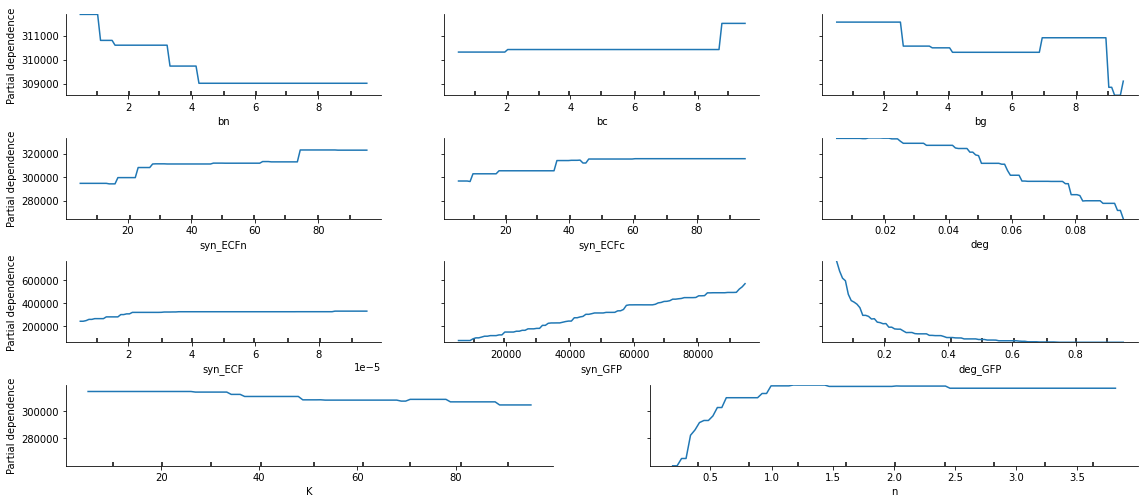

In [119]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(gb1, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(gb1, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(gb1, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(gb1, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

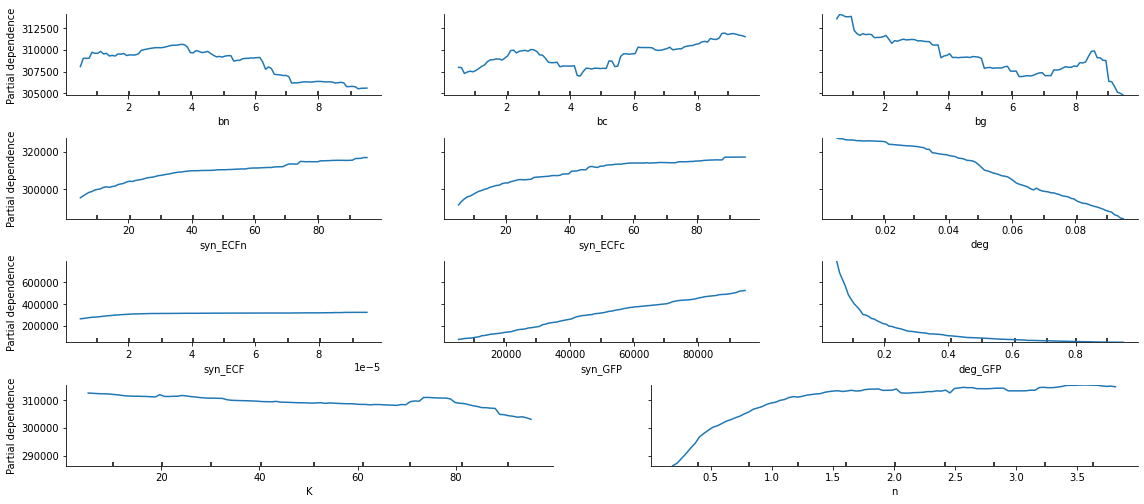

In [120]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(rf1, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(rf1, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(rf1, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(rf1, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

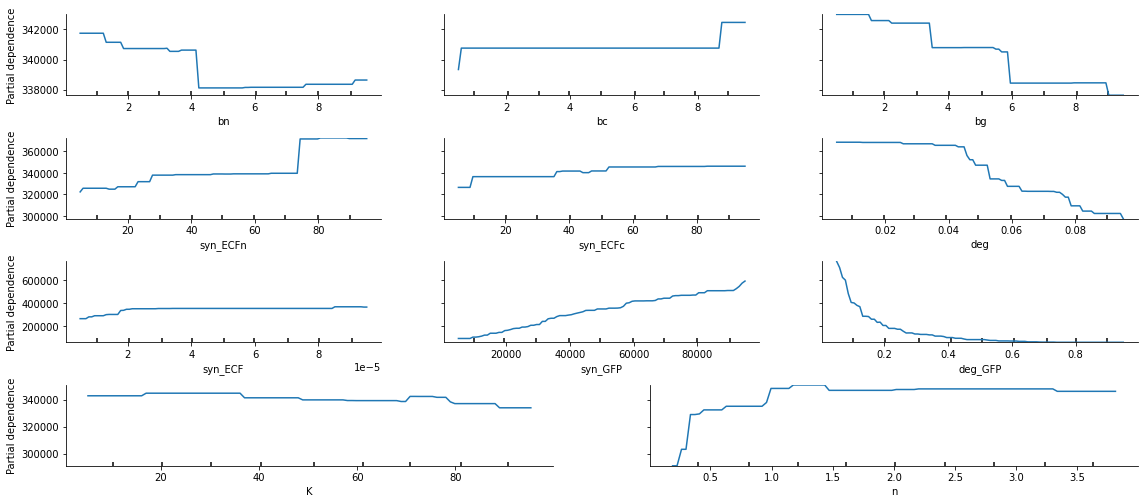

In [121]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(gb2, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(gb2, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(gb2, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(gb2, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

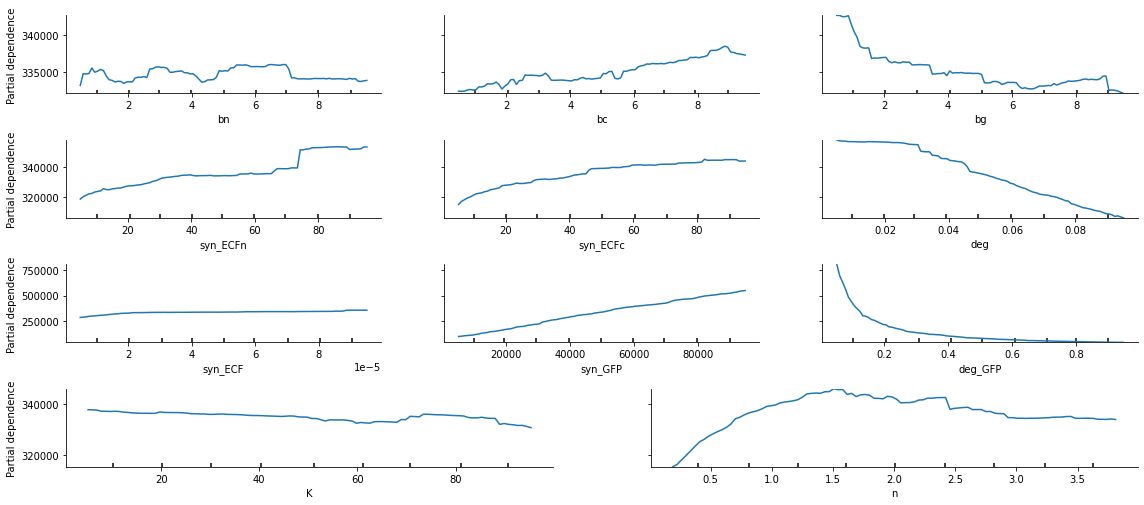

In [122]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(rf2, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(rf2, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(rf2, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(rf2, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

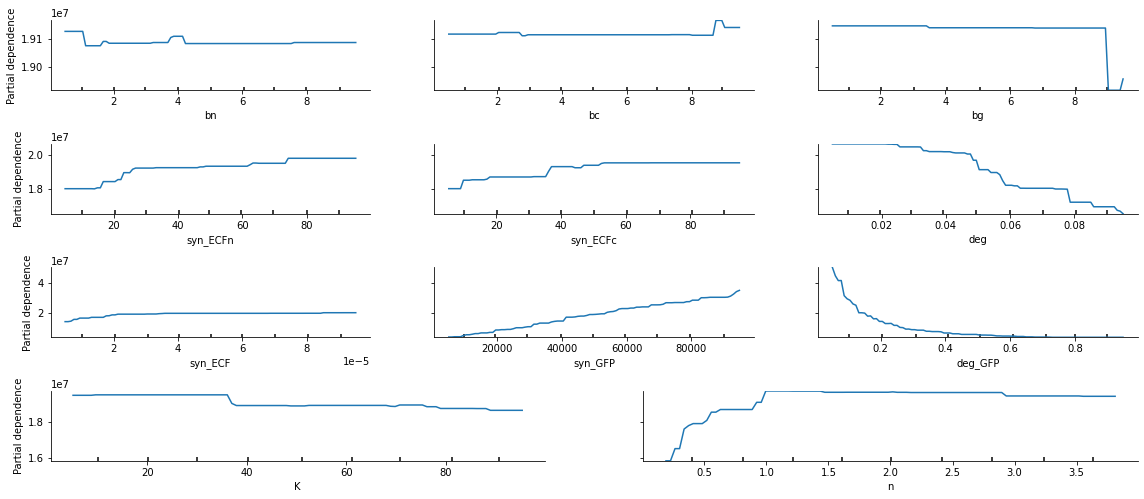

In [123]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(gb3, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(gb3, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(gb3, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(gb3, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

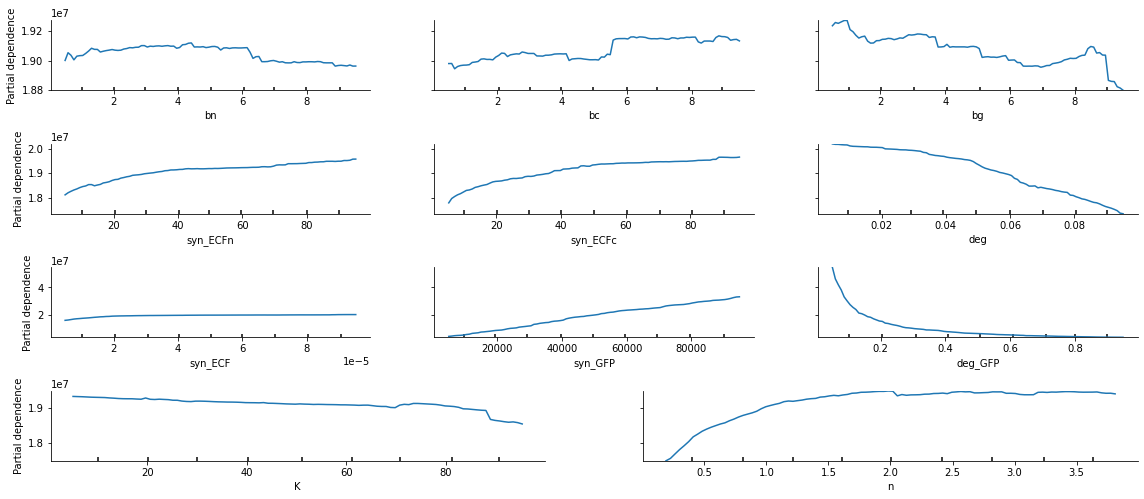

In [124]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(rf3, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(rf3, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(rf3, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(rf3, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

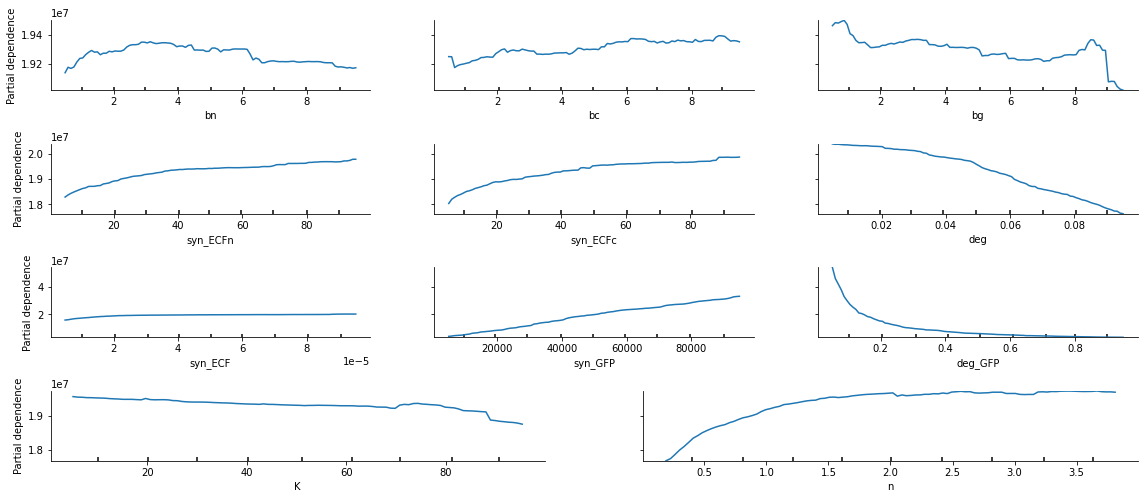

In [163]:
fig, ax = plt.subplots(4, 1, figsize=(16, 7))
plot_partial_dependence(rf3, X, [0, 1, 2], method='brute', ax=ax[0])
plot_partial_dependence(rf3, X, [3, 4, 6], method='brute', ax=ax[1])
plot_partial_dependence(rf3, X, [5, 7, 8], method='brute', ax=ax[2])
plot_partial_dependence(rf3, X, [9, 10], method='brute', ax=ax[3])
plt.tight_layout()
sns.despine()

In [150]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import Ridge, Lasso

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y_all, random_state=0)
mor = MultiOutputRegressor(RandomForestRegressor()).fit(X_train, y_train)

In [170]:
y_pred = mor.predict(X_test)
print(r2_score(y_test, y_pred))

0.8647624475394274


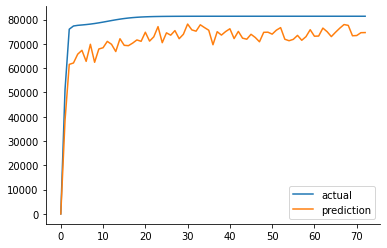

In [183]:
plt.plot(y_test[50], label='actual')
plt.plot(y_pred[50], label='prediction')
plt.legend()
sns.despine()

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y_all, random_state=0)
mor = RegressorChain(RandomForestRegressor()).fit(X_train, y_train)

In [185]:
y_pred = mor.predict(X_test)
print(r2_score(y_test, y_pred))

0.5151614331409987


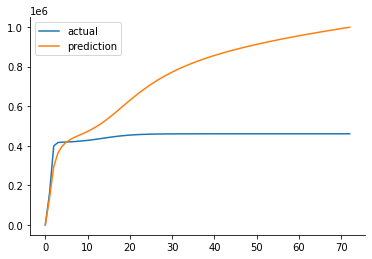

In [156]:
plt.plot(y_test[21], label='actual')
plt.plot(y_pred[21], label='prediction')
plt.legend()
sns.despine()

In [ ]:
const = sm.add_constant(X)
ols_model = sm.OLS(const, pd.Series(y_16))
result = ols_model.fit()
result.summary()